## Connecting to the Database

In [81]:
pip install psycopg2-binary;

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install mxnet

Note: you may need to restart the kernel to use updated packages.


In [83]:
import psycopg2

In [84]:
# Put the password in 
PGHOST = 'tripdatabase2.cmaaautpgbsf.us-east-2.rds.amazonaws.com'
PGDATABASE = ''
PGUSER = 'postgres'
PGPASSWORD = 'Josh1234'

In [85]:
# Database Context Manager
try:   
    # Set up a connection to the postgres server.    
    conn = psycopg2.connect(user = PGUSER,
                            port = "5432",
                            password = PGPASSWORD,
                            host = PGHOST,
                            database = PGDATABASE)
    # Create a cursor object
    cursor = conn.cursor()   
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Connection Success:", record,"\n")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)

Connection Success: ('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',) 



In [86]:
import pandas as pd
import numpy as np
import Queries
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [87]:
pd.set_option('display.max_colwidth', None)

## The Neighborhood Profile Data

In [88]:
profile_query = """SELECT * FROM neighborhoods.nyc_profile"""
profile_df = Queries.execute_query(conn, profile_query, to_frame=True)
profile_df.replace(-1, np.nan, inplace=True)   # Missing data was inputted into the database as -1
profile_df.set_index('code',inplace=True)

## Inputting Missing Data

In almost all the indicators (columns) of the dataframe there are values that skew the data in some way. When working with neighborhood data there are always values that skew an individual neighborhood's data which then skews the overall data. For the missing values in each indicator we will input the missing data with the median value of all the neighborhoods. 

***Since we will be clustering the neighborhoods, inputting the median value of an indicator grouped by the borough assumes that neighborhoods in the same borough have the same characteristics which is itself a clustering.***

In [89]:
from sklearn.impute import SimpleImputer

In [90]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp_mean.fit_transform(profile_df)
columns = profile_df.columns
index = profile_df.index

profile_df = pd.DataFrame(X, columns=columns, index=index)

## Boxplots & Correlations of the Data
Let's take some time to explore the data before we get into the machine learning portion. Since there are a lot of columns we are going to take it step by step by indicator family. The five families are:
- DEM: Demographics
- HSC: Housing Market & Conditions
- LUD: Land Use & Development
- NSC: Neighborhood Services & Conditions
- RNT: Renters

### **Family I - Demographics (DEM)**

In [91]:
dem = profile_df.loc[:,profile_df.columns.str[:3] == 'dem']

#### Boxplots of Demographics Family

In [92]:
numbers = ['dem5','dem7','dem8','dem9','dem14']   # Columns that aren't percentages
percents = [i for i in list(dem.columns) if i not in numbers]   # Columns that are percentages 

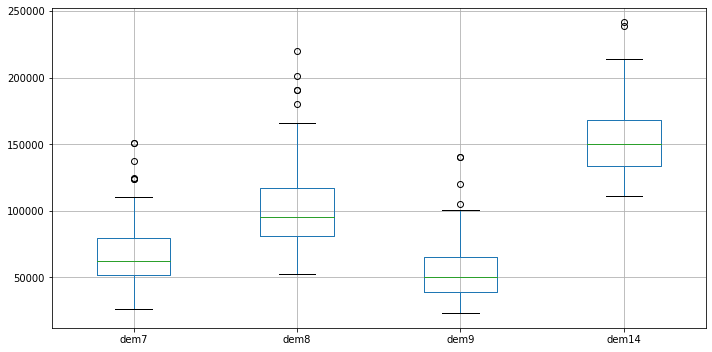

In [93]:
dem[numbers[1:]].boxplot(figsize=(10,5))   # We are skipping dem5 because it's not on the same scale
plt.tight_layout()

DEM7 (Median household income) and DEM9 (Median household income, renters) are almost identical. This shows that the majority of income in NYC is made by renters over homeowners. If more income was made by homeowners then DEM7 would look more like DEM8 (Median household income, homeowners). Although homewoners tend to make more money it didn't significantly pull up the overall median household income. 

DEM8/9 are a subdivision of DEM7. All three of them refer to the median household income of all members of the household aged 15 and over. The subdivisions calculate the same thing over a smaller subset of data. 

***Having these subdivisions carries with it a problem that we will discuss later on (See Correlations Within Demographics Family)*** 

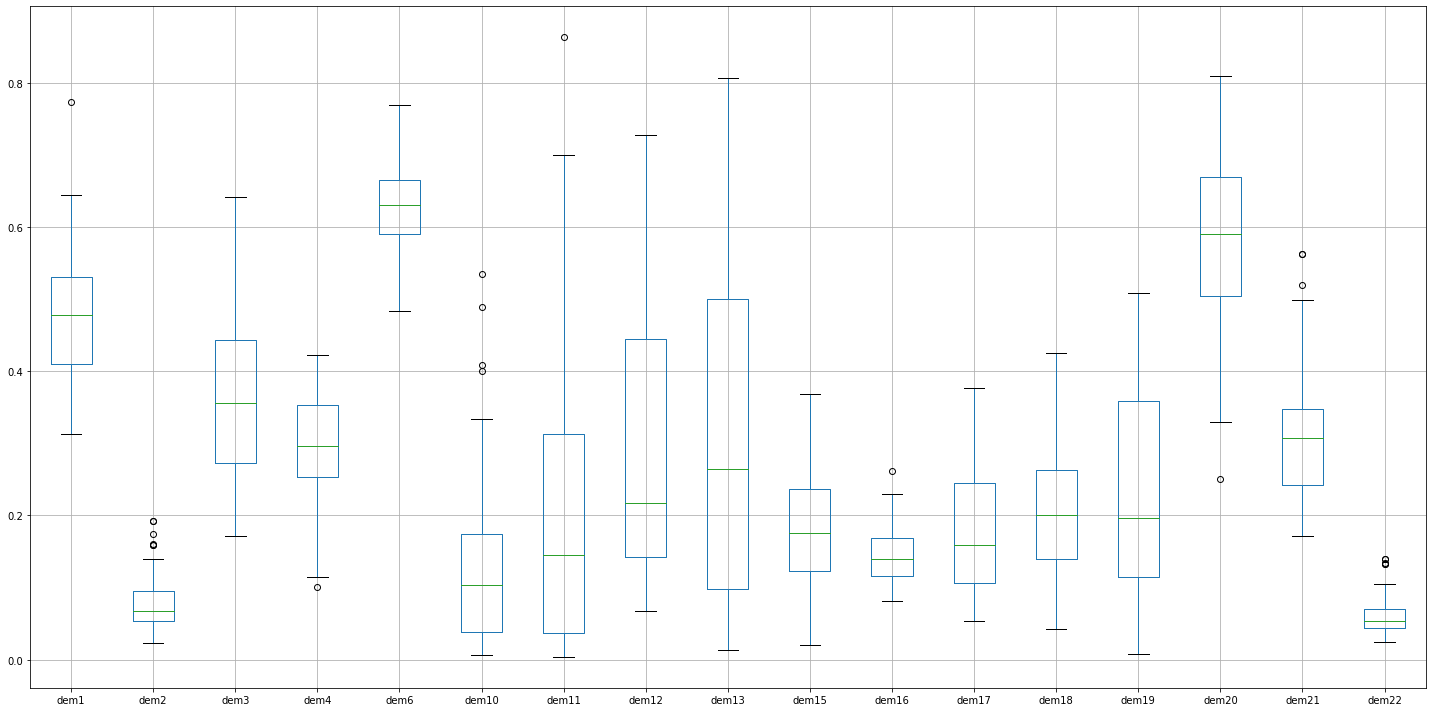

In [94]:
dem[percents].boxplot(figsize=(20,10))
plt.tight_layout()

In [95]:
dem[percents].describe()

,dem1,dem2,dem3,dem4,dem6,dem10,dem11,dem12,dem13,dem15,dem16,dem17,dem18,dem19,dem20,dem21,dem22
count,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.481356,0.080390,0.359017,0.291119,0.63478,0.133492,0.214729,0.298169,0.321966,0.177644,0.145627,0.179576,0.204407,0.229068,0.581186,0.317881,0.060927
std,0.089503,0.040323,0.117478,0.081308,0.06226,0.125464,0.220568,0.206382,0.241586,0.086797,0.040249,0.092851,0.092176,0.143636,0.108946,0.094711,0.028656
min,0.313000,0.023000,0.172000,0.101000,0.48400,0.007000,0.004000,0.067000,0.013000,0.020000,0.082000,0.054000,0.043000,0.008000,0.250000,0.171000,0.024500
25%,0.409500,0.053500,0.272500,0.254000,0.59100,0.039000,0.037000,0.142000,0.098500,0.123000,0.116500,0.106500,0.140000,0.115000,0.505000,0.242500,0.043800
50%,0.478000,0.068000,0.356000,0.297000,0.63000,0.103000,0.145000,0.218000,0.264000,0.176000,0.139000,0.159000,0.201000,0.197000,0.590000,0.308000,0.053100
75%,0.530500,0.095500,0.443500,0.353000,0.66550,0.174000,0.313000,0.444500,0.500000,0.237000,0.169000,0.245000,0.263000,0.359000,0.670000,0.347500,0.069750
max,0.774000,0.192000,0.642000,0.422000,0.76900,0.535000,0.863000,0.728000,0.806000,0.368000,0.262000,0.377000,0.425000,0.509000,0.810000,0.562000,0.140200


Although there are neighborhoods that are predominantly a single race of people, the majority of neighborhoods aren't. This is reflected in DEM20 (racial diversity index - the probability that two randomly chosen people in a given geographic area will be on a different race) with only 25% of the neighborhoods falling under a 50% probability.

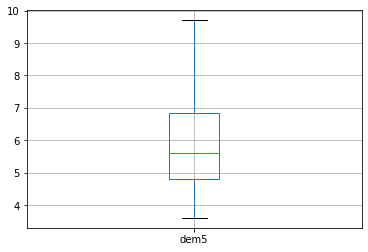

In [96]:
dem[['dem5']].boxplot()

NYC has a large gap between the 20th and 80th percentiles for the majority of neighborhoods. "Naturally" the 80th percentile should be 4x more than the 20th percentile. If the 80th is less than 4x then that means the 'rich' people of the area don't make that much more money than the 'poor' people (depending on how less). If it's more than 4x than the 'rich' people of the area make significantly more than the 'poor' people. Almost every neighborhood in the city has an income diversity ratio of more than 4. The borough of Manhattan being the most income diverse, holding 7 spots in the top 10 highest income diversity ratios.

#### Correlations Within Demographics Family

As mentioned above there are indicators that are divided into subdivisions and these subdivisions are stored as seperate indicators. For example DEM17 is the poverty rate, DEM18 is the poverty rate for population aged 65+, and DEM19 is the poverty rate for population under 18 years old. These subdivisions are redundent and when they are correlated to each other they add multicollinearity to the data. 

The major issue is that we are going to fit a PCA Dimensionality Reduction on the data in a later step and if a base property makes up most of the variance in a componenet then the subdivision most likely will as well. For example if Median household income has the most weight in a componenet then Median household income for homeowners will as well.

In [97]:
profile_df.drop(columns=['dem18','dem19'], inplace=True);   # Poverty subdivisions
profile_df.drop(columns=['dem8','dem9'], inplace=True);   # Median household income subdivisions

In [98]:
dem = profile_df.loc[:,profile_df.columns.str[:3] == 'dem']

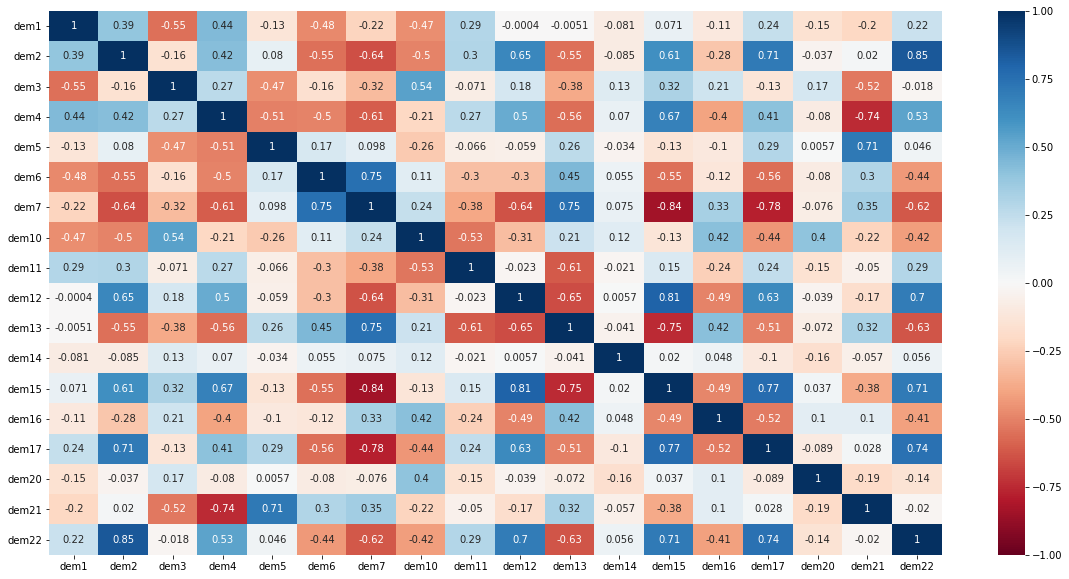

In [99]:
plt.figure(figsize=(20,10))
sns.heatmap(dem.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1, center=0);

Our data has a lot of multicollinearity and it makes sense that we do. For example, the greater the disabled population (DEM2) the greater the unemployement rate (DEM22) and the higher that is the lower the labor force participation rate (DEM6) and the less people working the greater the poverty rate (DEM17). 

### **Family II - Housing Market & Conditions (HSC)**

In [100]:
hsc = profile_df.loc[:,profile_df.columns.str[:3] == 'hsc']

There are three indicators that are broken into subdivisions in the same way:
- Index of housing price appreciation (HSC23 : HSC27)
- Median sales price per unit (HSC30 : HSC33)
- Sales volume (HSC48 : HSC52)

Each indicator is split into subdivision by the type of property (listed below). Unfortunately, the median sales price per unit indicator doesn't have a 'base'. Meaning there isn't a median sales price per unit for all property types, there are only the four subdivisions. If there was a base we would simply delete all the subdivisions and keep it. Because there is no base we can't delete the subdivisions and if we can't delete them in this indicator it wouldn't make sense to delete them in the other indicators. 
- All Property Types (What I call the 'Base')
- 1 Family Building
- 2-4 Family Building
- 5+ Family Building
- Condominium

The purpose of deleting subdivisions is that they aren't needed to represent the neighborhood, the base already does that. Using the same ideology we then only need to find the type of building/s that represent the majority of the neighborhood. To do that, we will use the Sales Volume category. Whichever building/s get bought the most often we will keep as columns. 

In [101]:
hsc.loc[:,'hsc48':'hsc52'].sum()   # HSC51 is the total

hsc48    11433.0
hsc49    10757.0
hsc50     1323.0
hsc51    33996.0
hsc52    10483.0
dtype: float64

1 family building (HSC48), 2-4 family buildings (HSC49), and condominiums (HSC52) are the most purchased buildings overall. *Note: (HSC51) represents all property types*. We will keep the indicators that relate to those buildings and delete the ones that don't (including the totals). *Some of the other columns that are going to be dropped are included*

In [102]:
profile_df.drop(columns=['hsc25','hsc26'], inplace=True)   # Index of housing price 5+ and Total
profile_df.drop(columns=['hsc32'], inplace=True)   # Median sales per unit 5+
profile_df.drop(columns=['hsc50','hsc51'], inplace=True)   # Sales volume 5+ and Total

In [103]:
profile_df.drop(columns=['hsc41','hsc42'], inplace=True)   # If there is a foreclosure then there was a preforeclosure for sure
profile_df.drop(columns=['hsc38','hsc39','hsc40'], inplace=True) # We are only keeping the notices of foreclosure of buildings 1-4 and condos for consistency 
profile_df.drop(columns=['hsc53'], inplace=True) # Serious housing code violation subdivision is correlated to total housing code violations 

In [104]:
hsc = profile_df.loc[:,profile_df.columns.str[:3] == 'hsc']

In [105]:
# The indicators that are on the same scale are grouped together
scale1 = ['hsc30','hsc31','hsc33']
scale2 = ['hsc23','hsc24','hsc27','hsc48','hsc49','hsc52','hsc55']
scale3 = ['hsc18','hsc37','hsc46']
scale4 = ['hsc11','hsc19','hsc20','hsc21','hsc47','hsc54']

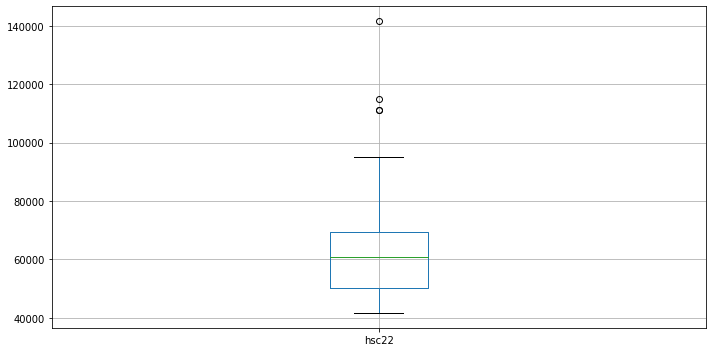

In [106]:
hsc[['hsc22']].boxplot(figsize=(10,5))
plt.tight_layout()

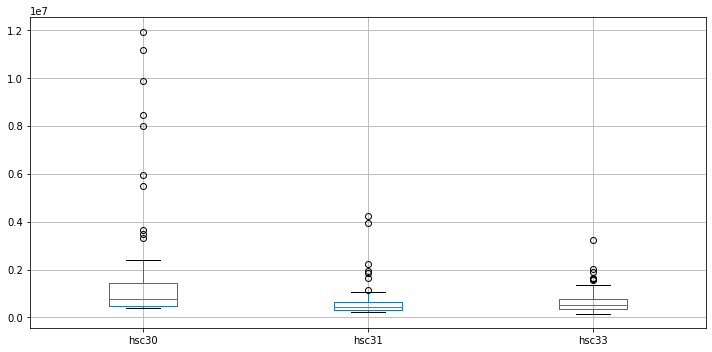

In [107]:
hsc[scale1].boxplot(figsize=(10,5))
plt.tight_layout()

There are some neighborhoods that have an outrageously high median house price. I'm going to guess it's Manhattan. Yep, Manhattan holds 8 of the 10 spots when it comes to highest median sales price. Which makes sense when the borough contains a thing called Billionaires' Row (https://en.wikipedia.org/wiki/Billionaires%27_Row_(Manhattan)).

On that note let's talk about outliers. We aren't going to try to 'fix' outliers, because the outliers are representative of the neighborhood. Some neighborhoods have a really high median sales price, some neighborhoods have a really low proportion of hispanic people. To handle the outliers we are going to scale the data when we get to the machine learning portion.

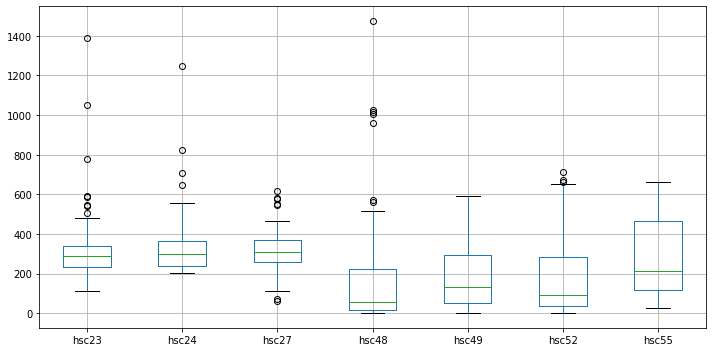

In [108]:
hsc[scale2].boxplot(figsize=(10,5))
plt.tight_layout()

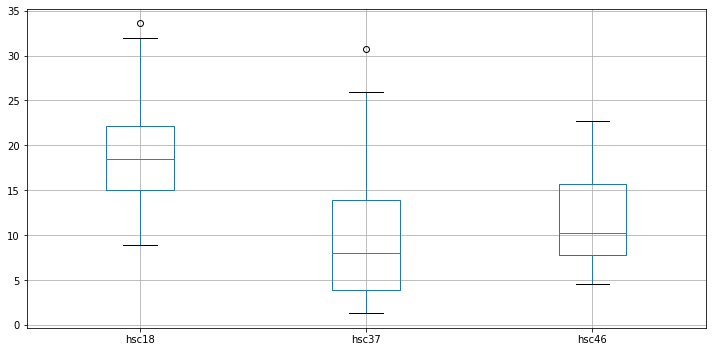

In [109]:
hsc[scale3].boxplot(figsize=(10,5))
plt.tight_layout()

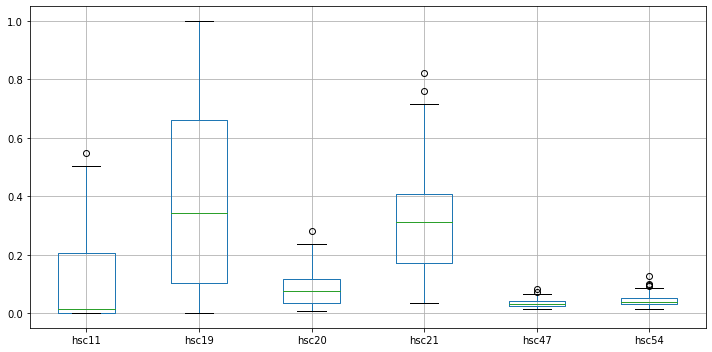

In [110]:
hsc[scale4].boxplot(figsize=(10,5))
plt.tight_layout()

#### Correlations Within Housing Family

In [111]:
hsc = profile_df.loc[:,profile_df.columns.str[:3] == 'hsc']

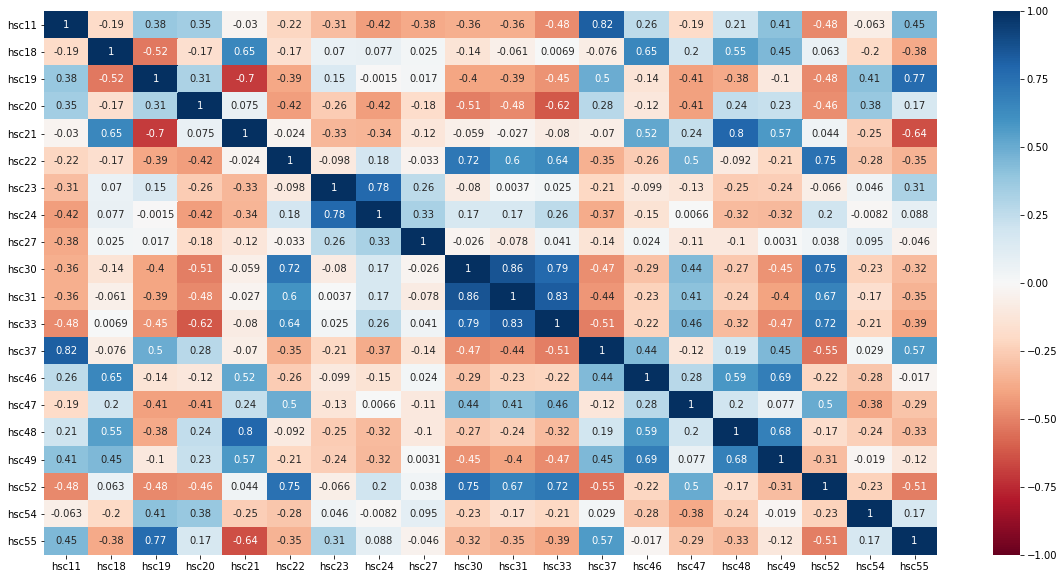

In [112]:
plt.figure(figsize=(20,10))
sns.heatmap(hsc.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1, center=0);

As the median sales price for each type of building goes up, the only sales volume that tends to go up is the condiminium volume. The other sales volumes (1 family and 2-4 family) tend to go down. In fact, a lot of things are correlated to the median price because the median price relates to the sales volume. For example, if the number of sales of buildings are decreasing then the number of foreclosure should also decrease as a consequence.

### **Family III - Land Use & Development**

In [113]:
lud = profile_df.loc[:,profile_df.columns.str[:3] == 'lud']

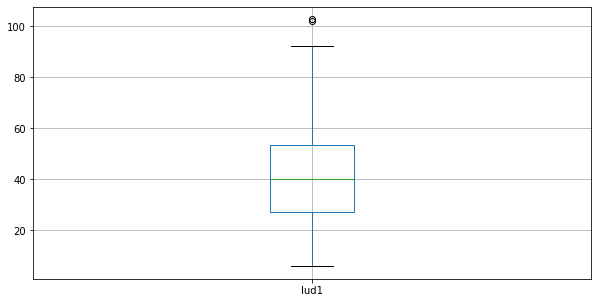

In [114]:
lud[['lud1']].boxplot(figsize=(10,5))

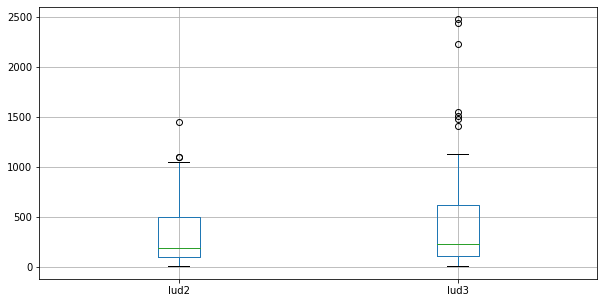

In [115]:
lud[['lud2','lud3']].boxplot(figsize=(10,5))

#### Correlations Within Land Family

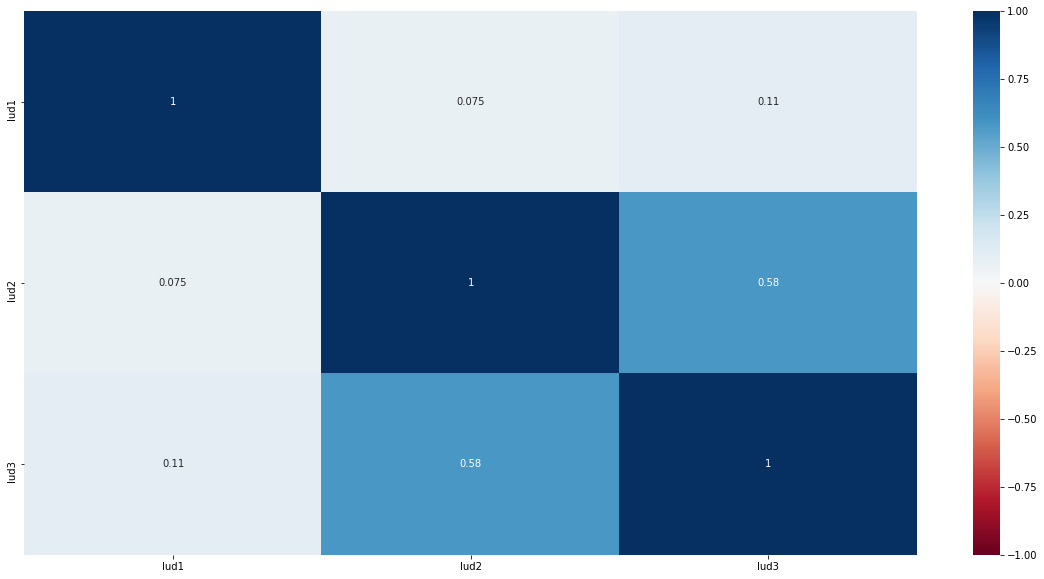

In [116]:
plt.figure(figsize=(20,10))
sns.heatmap(lud.corr(), cmap='RdBu', annot=True, vmin=-1,vmax=1, center=0);

### **Family IV - Neighborhood Services & Conditions**

In [117]:
profile_df.drop(columns=['nsc4','nsc5'], inplace=True)   # Serious crime rate subdivisions

In [118]:
nsc = profile_df.loc[:,profile_df.columns.str[:3] == 'nsc']

In [119]:
numbers = ['nsc2','nsc3']   # Columns that aren't percentages
percents = [i for i in list(nsc.columns) if i not in numbers]   # Columns that are percentages 

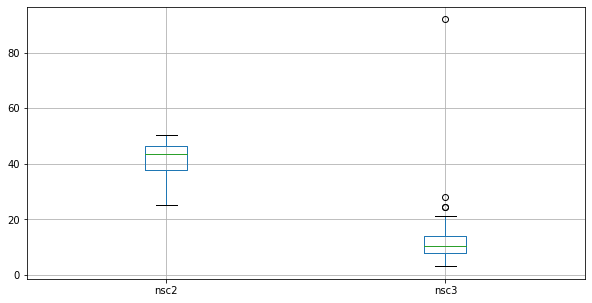

In [120]:
nsc[numbers].boxplot(figsize=(10,5))

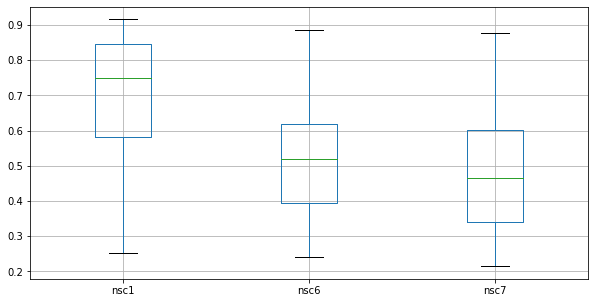

In [121]:
nsc[percents].boxplot(figsize=(10,5))

#### Correlations Within Neighborhood Family

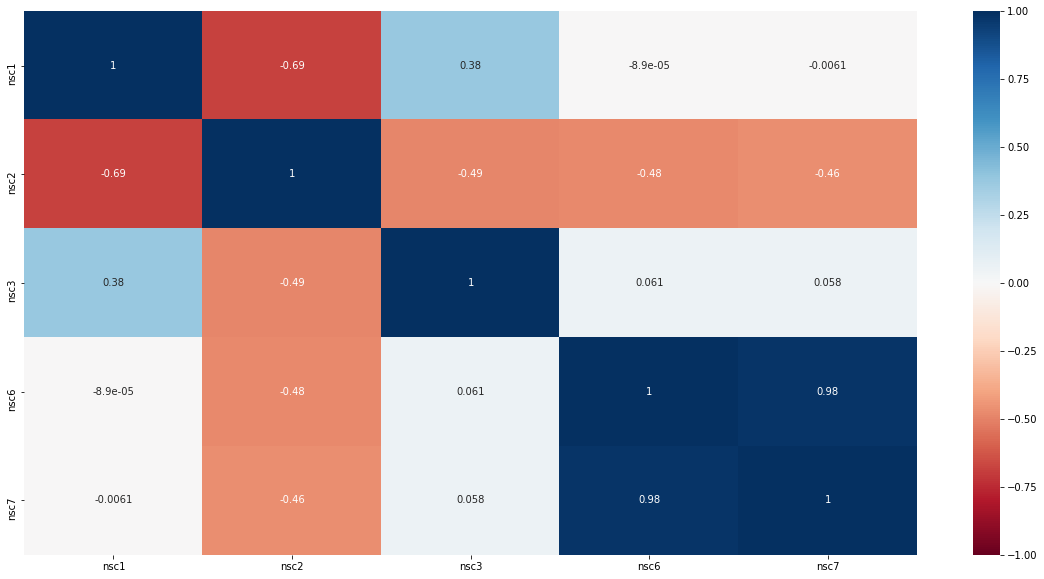

In [122]:
plt.figure(figsize=(20,10))
sns.heatmap(nsc.corr(), cmap='RdBu', annot=True, vmin=-1,vmax=1, center=0);

NSC6 (students performing at grade level in english, 4th grade) and NSC7 (same as NSC6, but for math) and nearly perfectly correlated. In terms of their correlations to other indicators they are correlated to in the same manner. There is no reason to keep both of them, since they are essentially the same. We'll keep the proficient in english indicator since being proficient in english helps in every subject whereas being proficient in math only helps a subset of subjects. 

In [123]:
profile_df.drop(columns=['nsc7'], inplace=True)

### **Family V - Renters**

In [124]:
profile_df.drop(columns=['rnt2','rnt4','rnt5','rnt6'], inplace=True)   # Median rent subdivisions
profile_df.drop(columns=['rnt8','rnt9'], inplace=True)   # Moderately rent-burdened households subdivisions
profile_df.drop(columns=['rnt15','rnt16'], inplace=True)   # Severly rent-burdened households subdivisions

In [125]:
rnt = profile_df.loc[:,profile_df.columns.str[:3] == 'rnt']

In [126]:
numbers = ['rnt3']
percents = [i for i in list(rnt.columns) if i not in numbers]

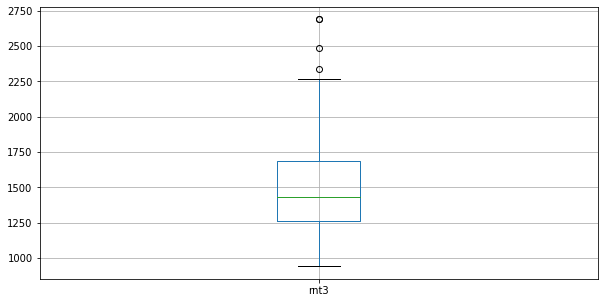

In [127]:
rnt[numbers].boxplot(figsize=(10,5));

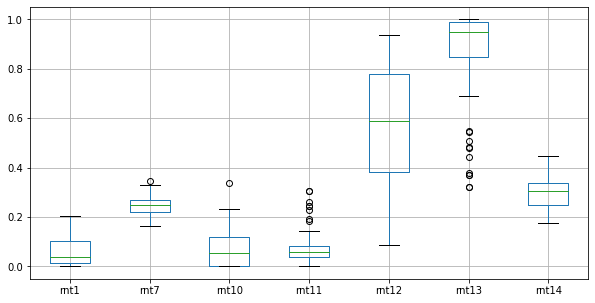

In [128]:
rnt[percents].boxplot(figsize=(10,5))

#### Correlations Within Renters Family

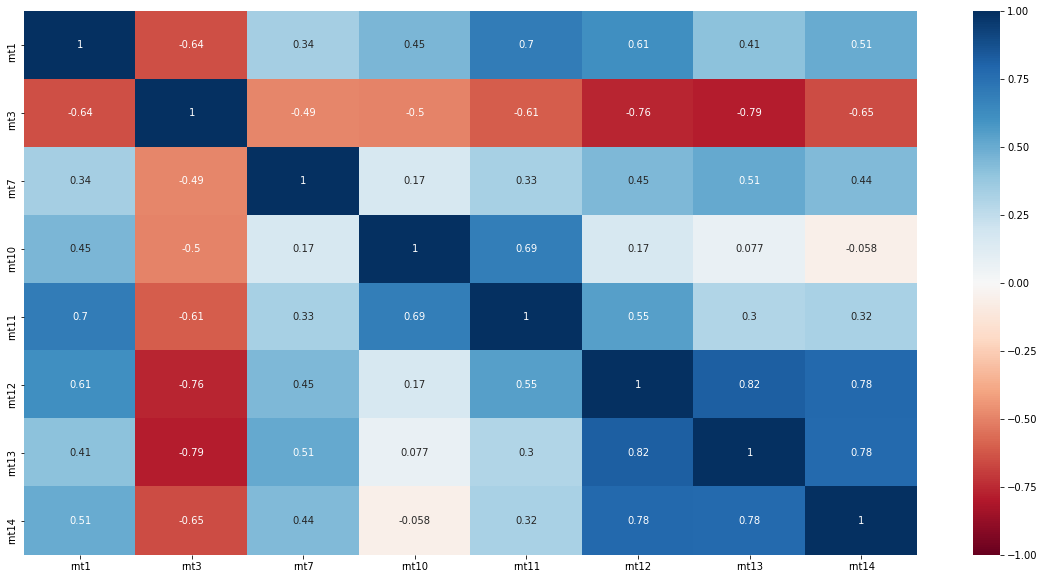

In [129]:
plt.figure(figsize=(20,10))
sns.heatmap(rnt.corr(), cmap='RdBu', annot=True, vmin=-1,vmax=1, center=0);

RNT3 (median rent) is correlated to every category in some way. Which is understandable being that every indicator in this family is related to cost in some way. Another interesting correlation is that as public housing tends to increase the amount of units that are affordable to people making 30% of the median income also increases. Public housing is generally cheaper than alternatives which could be the reason for this correlation

There are three categories called "Rental units affordable at [30,80,120]% AMI" (RNT11 - RNT13) and they are described as: the share of occupied, recently available rental units that are affordable to appropriately sized households with incomes at []% of the Area Median Income. If a rental unit is affordable to a household with income at 30% of the area median income then that same rental unit is affordable to a household with income at 80% and 120%. All rental units that contribute to their income level also contribute to the one above it. *Note: All rental units that contribute to their income level don't also contribute to the one below it.* 

In [130]:
rnt.loc[:,'rnt11':'rnt13'].describe()

,rnt11,rnt12,rnt13
count,59.000000,59.000000,59.000000
mean,0.080220,0.555458,0.853610
std,0.073488,0.246707,0.213294
min,0.000000,0.088000,0.321000
25%,0.039000,0.383500,0.848000
50%,0.057000,0.590000,0.950000
75%,0.083000,0.779000,0.990000
max,0.304000,0.937000,1.000000


The 120% AMI category encompases all the other categories and doesn't really add any valuable information which is why the 50th percentile of the data shows that 95% of properties are occupied.Every property that can be afforded by people with lower income, which is everybody, falls into this category. Additionally, in the heatmap this row is essentially identical to the 80% AMI category.

In [131]:
profile_df.drop(columns=['rnt13'], inplace=True)

## Regrouping NYC Neighborhoods via KMeans Clustering

### Step 1: Rescaling the Data

In [132]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [133]:
W = profile_df.copy()
columns = W.columns
index = W.index

The data needs to be scaled because the clustering algorithm uses a euclidean based distance metric. Even more so, there are a mixture of percents, regular numbers, and different units within the dataframe. Just using StandardScaler could potentially have a skew in the scaling due to the outlier values that exists in the different properties. What we'll do instead is use RobustScaler since it scales using the median and IQR instead of the mean and the standard deviation. After the Robust Scaling we will follow up with a StandardScaler to ensure that each column has a mean of 0 and a std of 1.

In [134]:
robust = RobustScaler()
W = robust.fit_transform(W)

In [135]:
pd.DataFrame(W).describe()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.027735,0.294996,0.017643,-0.059408,0.178586,0.064157,0.202586,0.225863,0.252641,0.265023,...,-0.172881,0.396810,0.011804,0.282994,0.281954,-0.030474,0.173571,0.527735,-0.087338,-0.126632
std,0.739693,0.960078,0.687003,0.821296,0.733925,0.835702,1.068549,0.929366,0.799159,0.682256,...,0.788996,1.968164,0.737179,0.676280,0.972712,0.789666,0.661893,1.670187,0.623786,0.728233
min,-1.363636,-1.071429,-1.076023,-1.979798,-0.975610,-1.959732,-1.294742,-0.711111,-0.510870,-0.499174,...,-2.129412,-1.260504,-1.236607,-0.438202,-1.152941,-1.676768,-0.448133,-1.295455,-1.269279,-1.517241
25%,-0.566116,-0.345238,-0.488304,-0.434343,-0.390244,-0.523490,-0.388387,-0.474074,-0.391304,-0.251240,...,-0.641176,-0.420168,-0.555804,-0.264045,-0.400000,-0.535354,-0.443983,-0.409091,-0.522124,-0.649425
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.433884,0.654762,0.511696,0.565657,0.609756,0.476510,0.611613,0.525926,0.608696,0.748760,...,0.358824,0.579832,0.444196,0.735955,0.600000,0.464646,0.556017,0.590909,0.477876,0.350575
max,2.446281,2.952381,1.672515,1.262626,2.000000,1.865772,3.111347,3.200000,2.601449,1.685950,...,0.823529,13.680672,1.638393,1.853933,2.964706,1.979798,2.348548,5.613636,0.877370,1.609195


Even after the RobustScaling there are still columns that vary more than the others.

In [136]:
standard = StandardScaler()
W = standard.fit_transform(W)

In [137]:
X = pd.DataFrame(W, columns=columns, index=index)
X.describe()

,dem1,dem2,dem3,dem4,dem5,dem6,dem7,dem10,dem11,dem12,...,nsc2,nsc3,nsc6,rnt1,rnt3,rnt7,rnt10,rnt11,rnt12,rnt14
count,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,...,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01
mean,5.268855e-17,-2.116951e-17,3.010774e-17,2.258081e-17,-6.021549e-17,-9.408670e-18,2.634428e-17,-2.822601e-17,-1.881734e-17,5.645202e-18,...,-1.336031e-16,-9.408670e-18,-1.505387e-17,-6.586069e-17,-8.655976e-17,-2.963731e-17,3.575294e-17,2.258081e-17,9.220496e-17,5.457028e-17
std,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,...,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00
min,-1.897159e+00,-1.435460e+00,-1.605602e+00,-2.358316e+00,-1.586134e+00,-2.442572e+00,-1.413301e+00,-1.016840e+00,-9.635926e-01,-1.129718e+00,...,-2.501060e+00,-8.492889e-01,-1.708034e+00,-1.075570e+00,-1.487812e+00,-2.102692e+00,-9.473435e-01,-1.100978e+00,-1.911051e+00,-1.925959e+00
25%,-8.097259e-01,-6.725806e-01,-7.427766e-01,-4.604360e-01,-7.817051e-01,-7.092134e-01,-5.578086e-01,-7.595988e-01,-8.126946e-01,-7.631951e-01,...,-5.986280e-01,-4.186594e-01,-7.765815e-01,-8.158372e-01,-7.071034e-01,-6.448459e-01,-9.410207e-01,-5.657256e-01,-7.029939e-01,-7.240557e-01
50%,-3.781713e-02,-3.099000e-01,-2.590150e-02,7.295493e-02,-2.454191e-01,-7.742864e-02,-1.912170e-01,-2.451154e-01,-3.188466e-01,-3.917856e-01,...,2.209966e-01,-2.033447e-01,-1.614966e-02,-4.220484e-01,-2.923521e-01,3.892254e-02,-2.644846e-01,-3.186859e-01,1.412155e-01,1.753815e-01
75%,5.537918e-01,3.779424e-01,7.253149e-01,7.676036e-01,5.925279e-01,4.976575e-01,3.860730e-01,3.256397e-01,4.493614e-01,7.151123e-01,...,6.796856e-01,9.378964e-02,5.915850e-01,6.755331e-01,3.297748e-01,6.323820e-01,5.827663e-01,3.814926e-02,9.138817e-01,6.609184e-01
max,3.297730e+00,2.791644e+00,2.429503e+00,1.623510e+00,2.503047e+00,2.174317e+00,2.745527e+00,3.227648e+00,2.964328e+00,2.100567e+00,...,1.273726e+00,6.807303e+00,2.225445e+00,2.342851e+00,2.781687e+00,2.567576e+00,3.314202e+00,3.071248e+00,1.559814e+00,2.404075e+00


Now every column has a mean of zero with a standard deviation of 1

### Step 2: Performing Dimensionality Reduction using PCA

There are 52 features in our dataset and with such a large feature space it may difficult difficult to cluster the neighborhoods effectively. Before sending the data to the K-Means algorithmn we are going to reduce the dimensionality of our data.

Code Derived From:

https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/US-census_population_segmentation_PCA_Kmeans/sagemaker-countycensusclustering.ipynb

In [138]:
import sagemaker
import boto3
import io
import sagemaker.amazon.common as smac
import os

In [139]:
sagemaker_session = sagemaker.Session()

bucket = 'williams-citibike'
prefix = 'Models/pca'
output_location = f"s3://{bucket}/{prefix}/output"

role = sagemaker.get_execution_role()

In [140]:
pca_model = sagemaker.PCA(role = role,
                          instance_count = 1,
                          instance_type = 'ml.m5.large',
                          output_path = output_location,
                          use_spot_instances = True,
                          max_run = 600,
                          max_wait = 600,
                          feature_dim = 52,
                          num_components = 51,
                          mini_batc_size = 5)

In [141]:
pca_model.fit(pca_model.record_set(X.values))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-03-15 11:21:39 Starting - Starting the training job...
2021-03-15 11:21:41 Starting - Launching requested ML instancesProfilerReport-1615807299: InProgress
......
2021-03-15 11:23:06 Starting - Preparing the instances for training......
2021-03-15 11:24:08 Downloading - Downloading input data
2021-03-15 11:24:08 Training - Downloading the training image...
2021-03-15 11:24:40 Uploading - Uploading generated training model
2021-03-15 11:24:40 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/15/2021 11:24:30 INFO 140568130729792] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[03/15/2021 11:24:30 INFO 140568130729792] Merg

In [142]:
job_name = pca_model.latest_training_job.name
#job_name = "pca-2021-03-15-00-44-05-602"
model_key = "Models/pca/output/" + job_name + "/output/model.tar.gz"
boto3.resource('s3').Bucket(bucket).download_file(model_key, './Data/Models/PCA/model.tar.gz');
os.system('tar -zxvf ./Data/Models/PCA/model.tar.gz');
os.rename("./model_algo-1", "./Data/Models/PCA/model_algo-1")

In [143]:
import mxnet as mx

In [144]:
pca_model_params = mx.ndarray.load('./Data/Models/PCA/model_algo-1')

In [145]:
s = pd.DataFrame(pca_model_params['s'].asnumpy())   # The singular values of the components for the PCA transformation
v = pd.DataFrame(pca_model_params['v'].asnumpy())   # The principal components

In [187]:
explained_variance_ratio = s.apply(lambda x: x*x) / s.apply(lambda x: x*x).sum()   # Calculates the explained variance ratio
explained_variance_ratio = explained_variance_ratio.sort_values(by=0, ascending=False)
explained_variance_ratio['explained_ratio_sum'] = explained_variance_ratio[0].cumsum()   # Sum of explained variance from great -> least
explained_variance_ratio.head(10)

,0,explained_ratio_sum
50,0.334029,0.334029
49,0.178447,0.512476
48,0.089731,0.602208
47,0.056016,0.658223
46,0.045225,0.703448
45,0.036940,0.740388
44,0.032922,0.773310
43,0.030210,0.803519
42,0.025053,0.828573
41,0.021586,0.850158


Components 50-43 explain 80% of the data's variance. We will take those 8 componenets and send them to the KMeans algorithm

In [147]:
s_8 = s.iloc[43:, :]
v_8 = v.iloc[:, 43:]
v_8.columns = [0,1,2,3,4,5,6,7]

In [200]:
def plot_components(two_list):
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))

    for component_num, axes in list(zip(two_list, [ax1,ax2])):
        current_comp = v_8[8-component_num]
        components_df = pd.DataFrame(list(zip(X.columns,current_comp)), columns=['features','weights'])
        components_df['abs_weights'] = components_df['weights'].apply(lambda x: np.abs(x))
        sns.barplot(data=components_df.sort_values('abs_weights', ascending=False).head(), x='weights', y='features', ax=axes)
        axes.set_title('PCA Component Makeup: #' + str(component_num));

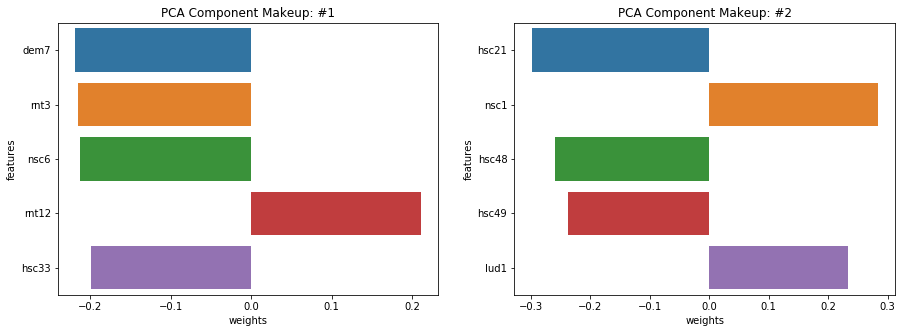

In [201]:
plot_components([1,2])

The first component (33% Explained Variance) looks like it describes a low income low rent neighborhood:
- DEM7: Median household income
- RNT3: Median rent, all
- NSC6: Students performing at grade level in ELA, 4th grade
- RNT12: Rentual units affordable at 80% AMI
- HSC33: Median sales price per unit, condominium

The second component (18% Explained Varaince) looks like it describes a highly urban area. Low homeownership and high car-free commute coupled with a high population density:
- HSC21: Homeownership rate
- NSC1: Car-free commute
- HSC48: Sales volume, 1 family building
- HSC49: Sales volume, 2-4 family building
- LUD1: Population density (1,000 persons per square mile)

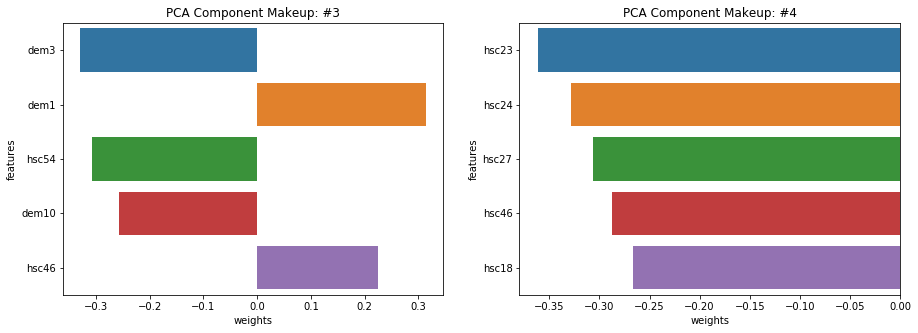

In [205]:
plot_components([3,4])

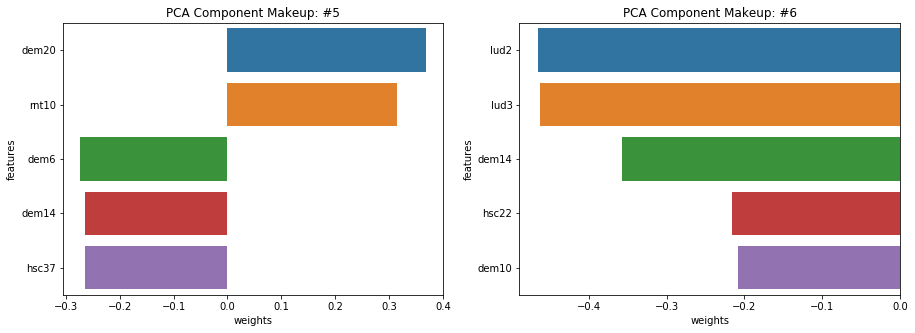

In [206]:
plot_components([5,6])

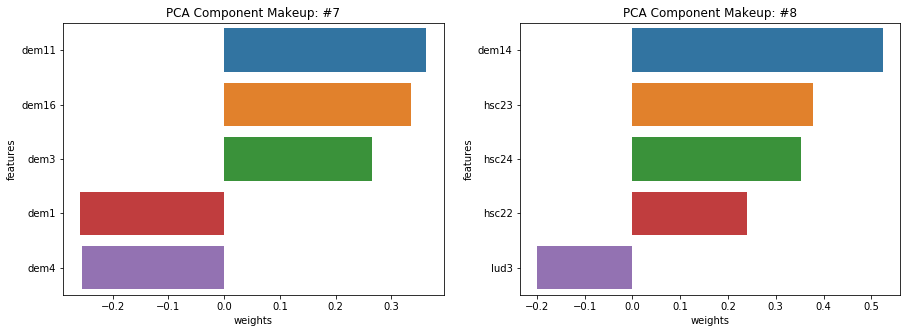

In [207]:
plot_components([7,8])

#### Deploying the PCA Model

In [149]:
pca_predictor = pca_model.deploy(initial_instance_count = 1,
                                  instance_type = 'ml.m5.large')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------!

In [150]:
result = pca_predictor.predict(X.values)   # The component values for each neighborhood as 

In [151]:
X_pca_transform = pd.DataFrame()

for i in result:   # Every iteration is a single neighborhood
    b = i.label['projection'].float32_tensor.values
    X_pca_transform = X_pca_transform.append([list(b)]) 

X_pca_transform.index = index   # Set the index to the hood codes
X_pca_transform = X_pca_transform.iloc[:,43:]   # Get the last 8 components
X_pca_transform.columns = ['comp8', 'comp7', 'comp6', 'comp5', 'comp4', 'comp3', 'comp2', 'comp1']

In [152]:
X_pca_transform.head()

,comp8,comp7,comp6,comp5,comp4,comp3,comp2,comp1
code,,,,,,,,
BK01,0.269478,-2.726194,-2.839694,0.492085,-2.768273,0.047136,2.651378,-3.279189
BK02,-0.683441,-1.967022,-2.252634,0.820364,-2.483774,1.049341,2.155579,-4.762545
BK03,0.058909,-0.039423,-0.791562,0.212722,-3.609241,1.831504,1.624672,0.505549
BK04,-1.383078,-0.813551,-0.531298,0.140760,-2.981160,-0.337737,1.885502,1.141638
BK05,-0.408980,0.706445,-1.284508,-1.900845,-0.494022,3.105196,0.048332,4.185757


### Step 3: Running the KMeans

In [153]:
prefix = 'Models/kmeans'
output_location = f"s3://{bucket}/{prefix}/output"

kmeans_model = sagemaker.KMeans(role = role,
                                instance_count = 1,
                                instance_type = 'ml.m5.large',
                                use_spot_instances = True,
                                max_run = 600,
                                max_wait = 600,
                                k = 5,
                                feature_dim = 6,
                                output_path = output_location)

In [ ]:
kmeans_model.fit(kmeans_model.record_set(X_pca_transform.values.astype('float32')))

In [155]:
kmeans_predictor = kmeans_model.deploy(initial_instance_count = 1,
                                       instance_type = 'ml.m5.large')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!

In [156]:
from sagemaker.deserializers import JSONDeserializer
kmeans_predictor.deserializer = JSONDeserializer()

In [160]:
result = kmeans_predictor.predict(X_pca_transform.values.astype('float32'))
clusters = [r['closest_cluster'] for r in result['predictions']]
X_pca_transform['labels'] = list(map(int,clusters))

#### KMeans Visualization

In [164]:
job_name = kmeans_model.latest_training_job.name
model_key = "Models/kmeans/output/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, './Data/Models/KMeans/model.tar.gz')
os.system('tar -zxvf ./Data/Models/KMeans/model.tar.gz');
os.rename("./model_algo-1", "./Data/Models/KMeans/model_algo-1")

In [168]:
kmeans_model_params = mx.ndarray.load('./Data/Models/KMeans/model_algo-1')

In [194]:
cluster_centroids = pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns = X_pca_transform.columns[:-1]

In [195]:
# 5 clusters in a 8D space
cluster_centroids

,comp8,comp7,comp6,comp5,comp4,comp3,comp2,comp1
0,0.408466,0.067018,-0.257831,-0.226703,-0.304645,1.614171,-4.436716,0.547558
1,0.035532,0.034482,-0.017669,0.587853,-2.329515,-0.262601,1.558054,-1.385245
2,0.058533,-0.776558,0.073153,-0.499854,1.400950,0.681120,3.564752,6.324242
3,-0.013900,0.010616,0.384411,-1.196380,1.674979,1.124237,2.516611,-8.610705
4,-0.172283,0.014322,0.379226,0.367373,0.421634,-1.215237,-1.320717,1.107319


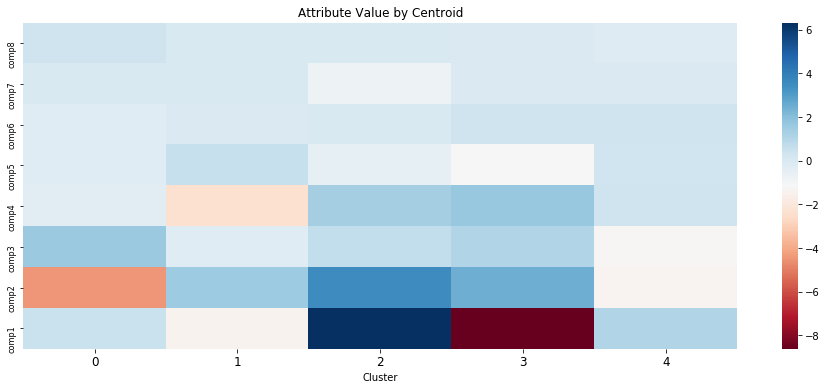

In [199]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'RdBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 12)
ax.set_title("Attribute Value by Centroid")
plt.show()

#### Delete Endpoints

In [ ]:
sagemaker.Session().delete_endpoint(pca_predictor)
sagemaker.Session().delete_endpoint(kmeans_predictor)